# Function to fit our analytical model to the SF-gas from TNG

This fit procedure is also described in section 3 of [van Son et al. 2023](https://ui.adsabs.harvard.edu/abs/2022arXiv220903385V/abstract).



In [46]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns

from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize as opt

# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2015 since that's what TNG uses
from astropy.cosmology import z_at_value
from IPython.display import Image # to open images in Ipython 

############################
# Custom scripts
sys.path.append('../')
import get_ZdepSFRD_no_omega_z as Z_SFRD
import importlib
import paths

import ReadFitData as read
importlib.reload(read)

#Change file names to match TNG version
Cosmol_sim_location = paths.data / "SFRMetallicityFromGasTNG50-1.hdf5"
fit_filename = 'best_fit_parameters_TNG50_no_omega_z.txt'
rbox = 35 #35 for 50, 75 for 100, 205 for 300
minimize_method = 'nelder-mead' #BFGS or nelder-mead

# First read the data that you want to fit to
***
We will have simulation data == TNG in our case
Make sure to convert it to a SFDR in Msun/yr/Mpc^-3

model data  == our analytical function

## Make sure you provide at least:

- Sim_SFRD = SFRD(z,Z)/($\Delta$Z), in $\rm{M}_{\odot} \rm{Mpc}^{-3}$
- MetalBins, in metallicity $Z$
- Lookbacktimes, in $\rm{Gyr}$

It is important that you provide the SFRD per dZ bin!! Otherwise your fit will be bin dependent, which is not what you want.. 



In [47]:
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)

In [48]:
minZ_popSynth    =  1e-6
## Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

## Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

## Convert lookback times to redshifts
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_Sim = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_Sim.append(0) # put redshift zero back at the end
redshifts_Sim = np.array(redshifts_Sim)

In [49]:
#########################################
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

#########################################
# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05)
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)
SFRDnew[SFRDnew < 0] = 0

In [50]:
##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = [],  simulation_SFRD = [],
                    mu_0  = 0.026, muz  =-0.09, sigma0  = 1.9, alpha =-3.3,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2):
    """
    Calculate the squared residual of your simulation_SFRD vs your analytical model.
    Args:
        fit_metals        --> [float]          metals used for fit
        Redshifts         --> [float]          redshifts used to fit
        simulation_SFRD   --> [float]          cosmological simulation data to fit to
        
        # metallicity distribution parameters (skew-log-normal)
        mu_0              --> [float]          location (mean in normal) at redshift 0
        muz               --> [float]          redshift evolution of the location
        sigma0            --> [float]          Scale at redshift 0 (variance in normal)
        alpha             --> [float]          shape (skewness, alpha = 0 retrieves normal dist)
        # overall SFR parameters
        sf_a              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square    --> [float ] 

    """ 
    #####################################
    # Get the SFR (Shape of Madau & Fragos 2014)
    sfr = Z_SFRD.Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value # Msun year-1 Mpc-3 
    # Get dPdZ (skew-log-normal distribution)
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(Redshifts,mu_z = muz , mu_0 = mu_0 ,
                                                  omega_0= sigma0 , alpha = alpha , 
                                                  metals=fit_metals)
    
    ######################################
    data           = simulation_SFRD                # Model comes in dP/dlogZ, so should your sim-data !
    model          = sfr[:,np.newaxis] * dPdlogZ 

    # The square of the residuals
    res_squared = ((data - model )**2)
    
    # Divide over the sum of the model at each redshift,
    # reduces contribution from high sfr redshifts & increases the weight where sfr is low
    chi_square = res_squared/np.sum(model, axis = 1)[:,np.newaxis]
    
    # Return sum Chi_squared and the max squared residual
    return np.sum(chi_square), data, model  

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [51]:
# Minimize the Chi_square

def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2] ):
    chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                       muz  =x0[0], mu_0  =x0[1],sigma0  =x0[2], alpha  =x0[3],
                                       sf_a =x0[4], sf_b=x0[5], sf_c=x0[6], sf_d=x0[7])
    return chi_square

# BEST GUESS
x0     = np.array([-0.15, 0.026, 1.1, -3.3, 0.01, 2.6, 3.2, 6.2])
bounds = ((-1., 0), (0.001, 0.1), (0.01, 5), (-10, 0), (None,None),(None,None),(None,None),(None,None))

# FIT
if minimize_method=='BFGS':
    res = minimize(test_chi, x0= x0, method='BFGS', options = {'gtol': 0.05})
else:
    res = minimize(test_chi, x0= x0, method=minimize_method)
    
# other options include: 'nelder-mead', L-BFGS-B, 'BFGS'
# Alternative: res = opt.basinhopping(test_chi, x0= x0, minimizer_kwargs={'method':'BFGS'})

In [52]:
print(res.success, res.message, 'N iterations: ', res.nit)
muz_best, mu0_best, sigma0_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3]
sf_a_best, sf_b_best, sf_c_best, sf_d_best               = res.x[4], res.x[5], res.x[6], res.x[7] 

print('\nBEST FITTING PARAMETERS:')
print('mu0 =%s, muz =%s, sigma_0 =%s, alpha=%s'% (mu0_best, muz_best, sigma0_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )

chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                   muz =muz_best, mu_0 =mu0_best,sigma0 =sigma0_best,alpha=alpha_best,
                                   sf_a =sf_a_best, sf_b=sf_b_best, sf_c=sf_c_best, sf_d=sf_d_best)
print('chi_square',chi_square, 'max_res_squared', np.amax( (data-model)**2) )

# Calculate standard error on params
from numpy.linalg import inv
N_elements  = len(data.flatten()) 
v = res['fun']/   N_elements  # variance of residuals, sse/n

True Optimization terminated successfully. N iterations:  1041

BEST FITTING PARAMETERS:
mu0 =0.045241152596981374, muz =-0.11362230486081194, sigma_0 =1.63966116633049, alpha=-1.5352927345141578
sf_a =0.04177108912308826, sf_b =1.3164014855228816, sf_c =3.818469760835285, sf_d =5.28289507927399
chi_square 0.14649048749214008 max_res_squared 0.00016606181366215155


In [53]:
if res.success:
    np.savetxt(paths.data / fit_filename,
               np.c_[mu0_best, muz_best, sigma0_best, alpha_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best],
               header = "mu0, muz, omega0, alpha0,sf_a, sf_b, sf_c, sf_d", delimiter=',', fmt="%s")


# Check SFRD(Z, z) fit

In [54]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a_best, b=sf_b_best, c=sf_c_best, d=sf_d_best).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz_best , mu_0 = mu0_best ,
                                                  omega_0= sigma0_best, alpha = alpha_best , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ

Zsun = 0.014 # Solar metallicity
cmap = sns.color_palette('rocket', as_cmap=True)

SFRDnew[SFRDnew < 0] = 0

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_87355/2033976822.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(data)


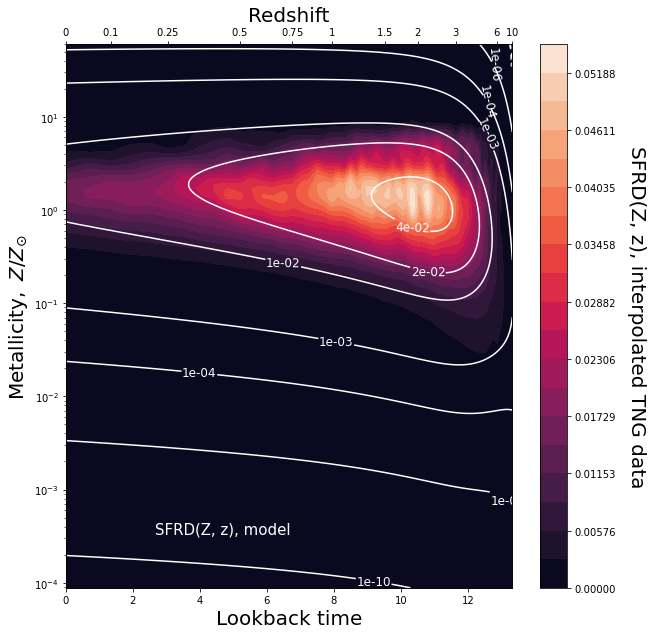

In [55]:
fig, ax = plt.subplots(figsize = (10,10))

levels = np.linspace(np.amin(SFRDnew), np.amax(SFRDnew), 20)
clevels = [1e-20, 1e-10, 1e-6, 1e-4, 1e-3, 0.01,0.02, 0.04, 0.05]

data = ax.contourf(Lookbacktimes_new, metals_new/Zsun, SFRDnew, levels=levels, cmap=cmap)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.clabel(modelplot, fontsize=12, inline=True, fmt = '%.0e')

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.1, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))
ax2.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))

cbar = fig.colorbar(data)
cbar.set_label('SFRD(Z, z), interpolated TNG data', rotation=270, fontsize=20, labelpad=30)

fig.savefig("SFRD_Z_z_TNG_no_omegaz.png", bbox_inches='tight')

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_87355/1801852470.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(data)


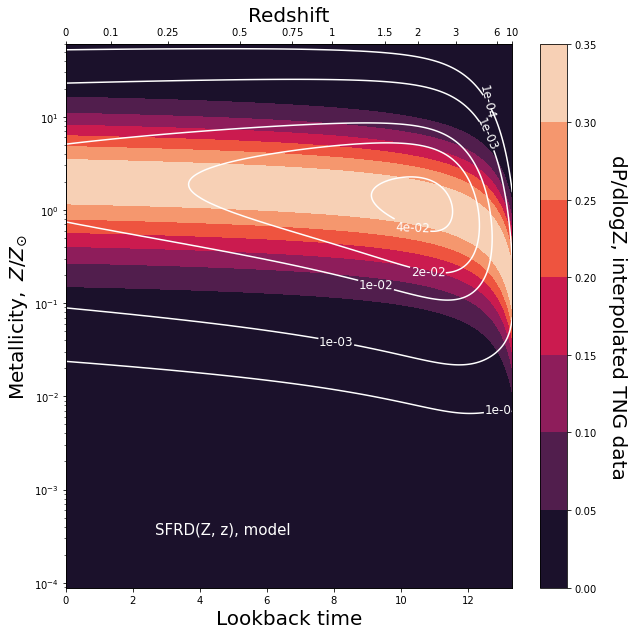

In [56]:
fig, ax = plt.subplots(figsize = (10,10))

#levels = np.linspace(np.amin(dPdlogZ), np.amax(dPdlogZ), 20)
clevels = [1e-4, 1e-3, 0.01,0.02,0.04, 0.05]

data = ax.contourf(Lookbacktimes_new, metals_new/Zsun, dPdlogZ.T, cmap=cmap)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.clabel(modelplot, fontsize=12, inline=True, fmt = '%.0e')

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.1, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))
ax2.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))

cbar = fig.colorbar(data)
cbar.set_label('dP/dlogZ, interpolated TNG data', rotation=270, fontsize=20, labelpad=30)

fig.savefig("dpdlogZ_Z_z_TNG_no_omegaz.png", bbox_inches='tight')

# Compare SFRDs

Text(0, 0.5, 'SFRD(Z, z)')

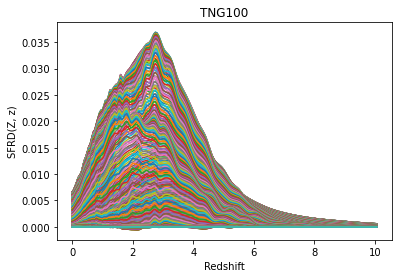

In [9]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a_best, b=sf_b_best, c=sf_c_best, d=sf_d_best).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz_best , mu_0 = mu0_best ,
                                                  omega_0= sigma0_best, alpha = alpha_best , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ
plt.plot(redshift_new, SFRDnew.T); #simulation
#plt.plot(redshift_new, np.mean(model, axis=1), 'k', lw=3); #fitted model, best fit
plt.title("TNG100")
plt.xlabel("Redshift")
plt.ylabel("SFRD(Z, z)")
#plt.savefig("figures/checking_fit/SFRD_TNG100_no_omegaz.png")

In [10]:
# Note that in lower res, see clearer two peak shape. Box size affects how wobbly lines are

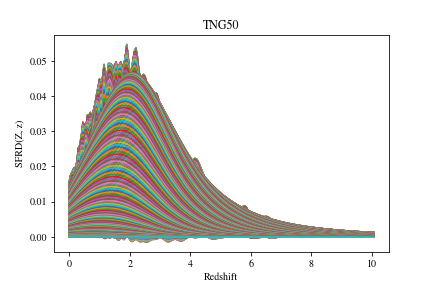

In [11]:
Image(filename='figures/checking_fit/SFRD_TNG50_no_omegaz.png') 

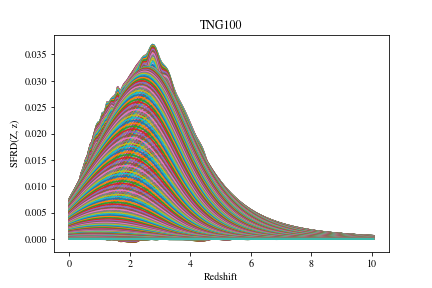

In [12]:
Image(filename='figures/checking_fit/SFRD_TNG100_no_omegaz.png') 

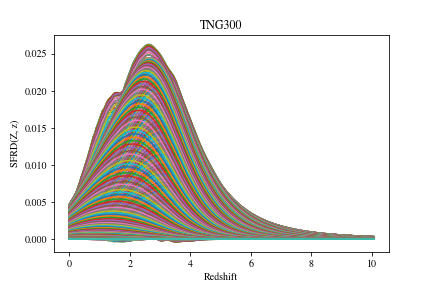

In [13]:
Image(filename='figures/checking_fit/SFRD_TNG300_no_omegaz.png') 

## Compare parameters to model with omega_z

In [32]:
new_vals = np.loadtxt(paths.data / "best_fit_parameters_TNG50_no_omega_z.txt", skiprows=1, delimiter=",")
old_vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG50.txt", skiprows=1, delimiter=",")
ticks =  ["mean metallicity at z=0", "redshift evolution of mean", "variance in metallicity density distribution", "redshift evolution of variance", "skewness","SFR scaling", "SFR upward slope", "SFR peak location", "SFR downward slope"]

In [33]:
new_vals

array([ 0.04501215, -0.11351362,  1.64344434, -1.55270845,  0.04175389,
        1.3164432 ,  3.81845167,  5.2829286 ])

In [34]:
new_vals = [ 0.04501215, -0.11351362,  1.64344434, None, -1.55270845,  0.04175389, 1.3164432 ,  3.81845167,  5.2829286 ]
new_vals = np.array(new_vals)

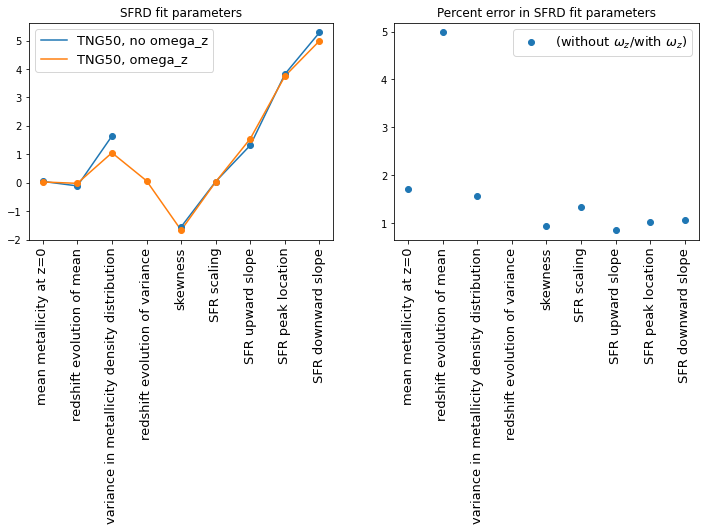

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x1 = [0,1,2,3,4,5,6,7,8]
x2 = [0,1,2,3,4,5,6,7,8]

ax[0].plot(x1, new_vals, label='TNG50, no omega_z',)
ax[0].plot(x2, old_vals, label="TNG50, omega_z")
ax[0].plot(x1, new_vals, 'o', c='tab:blue')
ax[0].plot(x2, old_vals, 'o', c='tab:orange')
ax[0].set_xticks(x1)
ax[0].set_xticklabels(ticks, rotation=90, fontsize=13)
ax[0].legend(fontsize=13)
ax[0].set_title('SFRD fit parameters')

for i in x1:
    try: 
        if i==0:
            ax[1].plot(x1[i], new_vals[i]/old_vals[i], 'o', c='tab:blue', label=r'(without $\omega_z$/with $\omega_z$)')
        else:
            ax[1].plot(x1[i], new_vals[i]/old_vals[i], 'o', c='tab:blue')
    except TypeError: 
        continue
ax[1].set_xticks(x1)
ax[1].set_xticklabels(ticks, rotation=90, fontsize=13)
ax[1].legend(fontsize=13)
ax[1].set_title('Percent error in SFRD fit parameters');
fig.savefig('figures/checking_fit/parameters_omega_z.png', bbox_inches='tight')

## Compare fit parameters across TNGs

In [29]:
tng100vals = np.loadtxt(paths.data / "best_fit_parameters_TNG50_no_omega_z.txt", skiprows=1, delimiter=",")
tng50vals = np.loadtxt(paths.data / "best_fit_parameters_TNG100_no_omega_z.txt", skiprows=1, delimiter=",")
tng300vals = np.loadtxt(paths.data / "best_fit_parameters_TNG300_no_omega_z.txt", skiprows=1, delimiter=",")
ticks =  ["mean metallicity at z=0", "redshift evolution of mean", "variance in metallicity density distribution",  "skewness","SFR scaling", "SFR upward slope", "SFR peak location", "SFR downward slope"]

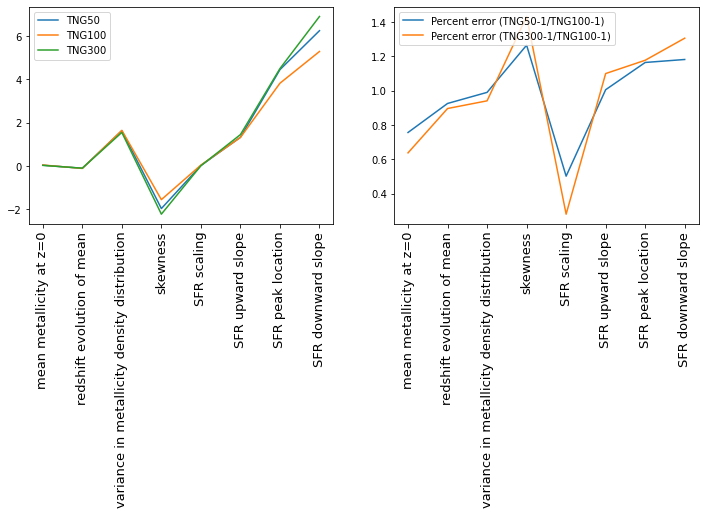

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x = [0,1,2,3,4,5,6,7]

ax[0].plot(x, tng50vals, label="TNG50")
ax[0].plot(x, tng100vals, label='TNG100')
ax[0].plot(x, tng300vals, label="TNG300")
ax[0].set_xticks(x)
ax[0].set_xticklabels(ticks, rotation=90, fontsize=13)
ax[0].legend(fontsize=10);

ax[1].plot(x, tng50vals/tng100vals, label='Percent error (TNG50-1/TNG100-1)')
ax[1].plot(x, tng300vals/tng100vals, label='Percent error (TNG300-1/TNG100-1)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(ticks, rotation=90, fontsize=13)
ax[1].legend(fontsize=10);

# Visualize the fit

Let's try to visualize how well our fit matches the simulation, by plotting the **squared residuals**:

\begin{equation}
\log_{10} \lvert \mathcal{S}(Z_i, z_j)_{sim} - \mathcal{S}(Z_i, z_j)_{fit} \rvert
\end{equation}


And the relative error


\begin{equation}
\log_{10} \frac{\lvert \mathcal{S}(Z_i, z_j)_{sim} - \mathcal{S}(Z_i, z_j)_{fit} \rvert}{\mathcal{S}(Z_i, z_j)_{fit}}
\end{equation}



(202, 500)
(202,) (500,)
[-7. -6. -5. -4. -3. -2.]


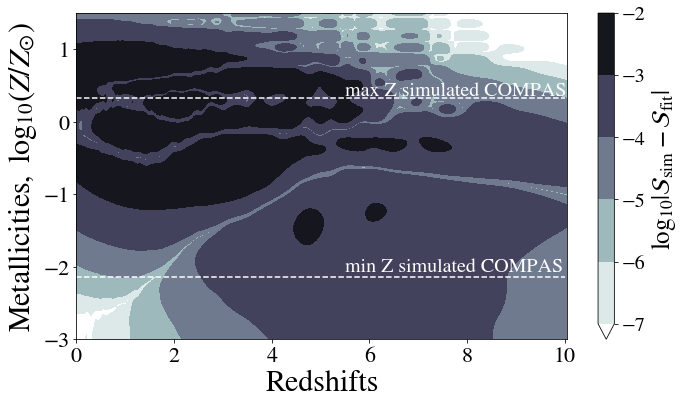

In [47]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

res_squared = (data - model)**2
print(np.shape(res_squared))
print(np.shape(redshift_new),np.shape(metals_new))
Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-7, -2, num=6)
print(levs)
cs = plt.contourf(X, Y, np.log10( abs(data-model).T), 
                  levs, cmap ="bone_r",extend ='min')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} | \mathcal{S}_{\rm sim} -\mathcal{S}_{\rm fit}| $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)


# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5.5, np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5.5, np.log10(0.032/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')

######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.savefig(paths.figures / 'checking_fit/log_res_no_omegaz.pdf',  bbox_inches='tight')
plt.show()


-5.788985857311884 5.36686569588982
[-3. -2. -1.  0.  1.  2.  3.]


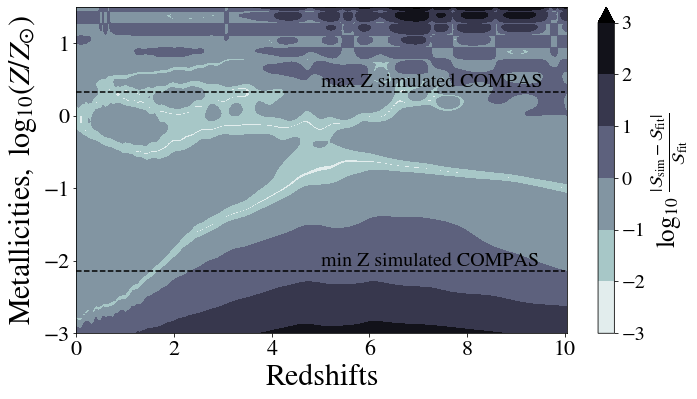

In [48]:
############################
abs_relative_err = abs(data-model)/model
Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-3, 3, num=7)
print(np.amin(np.log10(abs_relative_err)), np.amax(np.log10(abs_relative_err))) 
print(levs)
cs = plt.contourf(X, Y, np.log10((abs_relative_err).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \frac{| \mathcal{S}_{\rm sim} - \mathcal{S}_{\rm fit} | }{\mathcal{S}_{\rm fit}} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.savefig(paths.figures / 'checking_fit/log_relative_err_no_omegaz.pdf',  bbox_inches='tight')
plt.show()


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_4268/2846804007.py:20: RuntimeWarning: divide by zero encountered in log10
  cs = plt.contourf(X, Y, np.log10((Sim_SFRD).T),


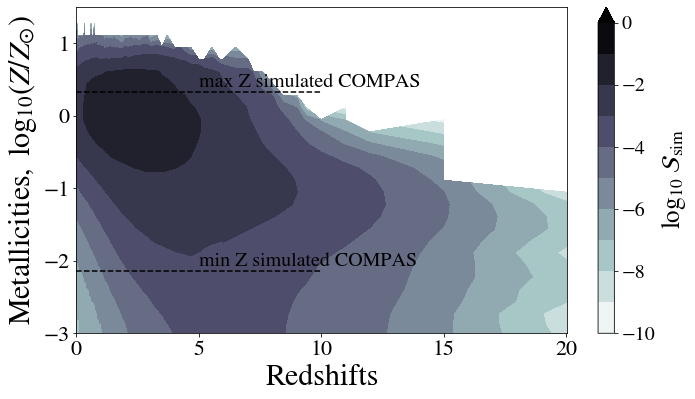

In [49]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(Redshifts,  np.log10(Sim_center_Zbin/Zsun))

levs = np.linspace(-10, 0, num=11)
print(levs)
cs = plt.contourf(X, Y, np.log10((Sim_SFRD).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \mathcal{S}_{\rm sim} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.show()


[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


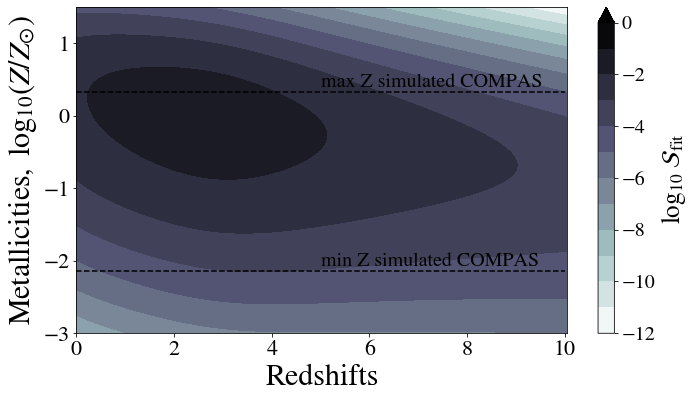

In [50]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-12, 0, num=13)
print(levs)
cs = plt.contourf(X, Y, np.log10((model).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \mathcal{S}_{\rm fit} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.show()
